# Simple Microscope Simulation - Biological Cell

This notebook demonstrates simulating microscope imaging of a biological cell using the `simple_microscope` function.

## Overview

We create a biological cell model with:
1. **Surrounding medium** - Water-like background (n ≈ 1.337)
2. **Cytoplasm** - Cell body (n ≈ 1.360-1.380)
3. **Nucleus** - Dense core (n ≈ 1.380-1.400)

The 3D cell is projected to 2D via optical path length integration, then imaged with the simple microscope model.

## Imports

In [1]:
import janssen as jns
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as cmo
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Rectangle

In [2]:
jns.__version__

'2025.10.4'

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Simulation Parameters

We create a sample that is large enough to contain the cell and allow for scanning.

In [4]:
pixel_size = 0.5e-6  # 0.5 microns
num_pixels = 512  # Smaller grid for cell
num_slices = 64   # Number of z-slices for 3D cell
slice_thickness = 1e-6  # 1 micron per slice
wavelength = 633e-9  # 633 nm (HeNe laser)

# Cell parameters
cell_radius = 25e-6     # 25 micron cell radius
nucleus_radius = 8e-6   # 8 micron nucleus radius

# Refractive indices (typical values for biological tissue)
n_medium = 1.337 + 0.0j      # Water
n_cytoplasm = 1.360 + 0.001j  # Cytoplasm (slight absorption)
n_nucleus = 1.390 + 0.002j    # Nucleus (denser, more absorption)

print(f"Pixel size: {pixel_size * 1e6:.1f} microns")
print(f"Grid size: {num_pixels} x {num_pixels} pixels")
print(f"Field of view: {pixel_size * num_pixels * 1e6:.0f} microns")
print(f"Number of z-slices: {num_slices}")
print(f"Total z-depth: {num_slices * slice_thickness * 1e6:.0f} microns")
print(f"Wavelength: {wavelength * 1e9:.0f} nm")
print(f"Cell radius: {cell_radius * 1e6:.0f} microns")
print(f"Nucleus radius: {nucleus_radius * 1e6:.0f} microns")

Pixel size: 0.5 microns
Grid size: 512 x 512 pixels
Field of view: 256 microns
Number of z-slices: 64
Total z-depth: 64 microns
Wavelength: 633 nm
Cell radius: 25 microns
Nucleus radius: 8 microns


## 1. Create 3D Biological Cell Model

Using `biological_cell` from material_models to create a 3D refractive index distribution with nucleus, cytoplasm, and surrounding medium.

In [5]:
# Create 3D biological cell
cell_3d = jns.models.biological_cell(
    shape=(num_pixels, num_pixels, num_slices),
    cell_radius=cell_radius,
    nucleus_radius=nucleus_radius,
    n_cytoplasm=n_cytoplasm,
    n_nucleus=n_nucleus,
    n_medium=n_medium,
    dx=pixel_size,
    tz=slice_thickness,
)

print(f"3D Cell shape: {cell_3d.material.shape}")
print(f"Cell dx: {cell_3d.dx * 1e6:.2f} microns")
print(f"Cell tz: {cell_3d.tz * 1e6:.2f} microns")

3D Cell shape: (512, 512, 64)
Cell dx: 0.50 microns
Cell tz: 1.00 microns


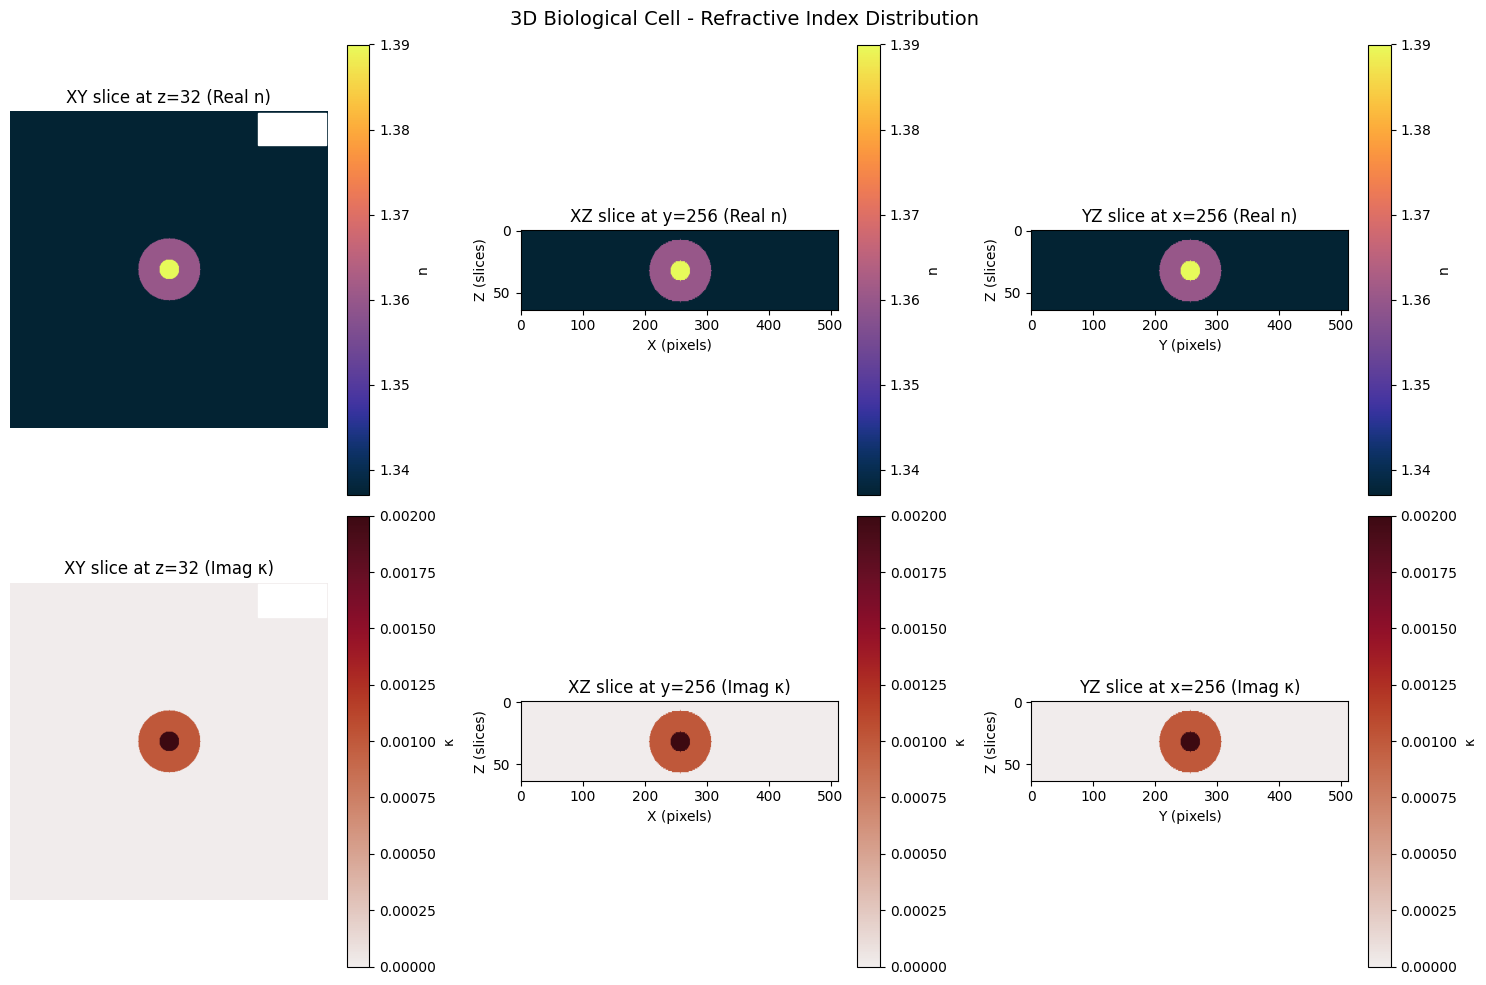

In [6]:
# Visualize the 3D cell - show cross-sections
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Middle slices
mid_z = num_slices // 2
mid_y = num_pixels // 2
mid_x = num_pixels // 2

# XY slice (top view) - real part of refractive index
im00 = axes[0, 0].imshow(jnp.real(cell_3d.material[:, :, mid_z]), cmap=cmo.thermal)
axes[0, 0].set_title(f'XY slice at z={mid_z} (Real n)')
scalebar = ScaleBar(cell_3d.dx, 'm', length_fraction=0.25, color='white')
axes[0, 0].add_artist(scalebar)
axes[0, 0].axis('off')
plt.colorbar(im00, ax=axes[0, 0], label='n')

# XZ slice (side view)
im01 = axes[0, 1].imshow(jnp.real(cell_3d.material[mid_y, :, :]).T, cmap=cmo.thermal, aspect=slice_thickness/pixel_size)
axes[0, 1].set_title(f'XZ slice at y={mid_y} (Real n)')
axes[0, 1].set_xlabel('X (pixels)')
axes[0, 1].set_ylabel('Z (slices)')
plt.colorbar(im01, ax=axes[0, 1], label='n')

# YZ slice (side view)
im02 = axes[0, 2].imshow(jnp.real(cell_3d.material[:, mid_x, :]).T, cmap=cmo.thermal, aspect=slice_thickness/pixel_size)
axes[0, 2].set_title(f'YZ slice at x={mid_x} (Real n)')
axes[0, 2].set_xlabel('Y (pixels)')
axes[0, 2].set_ylabel('Z (slices)')
plt.colorbar(im02, ax=axes[0, 2], label='n')

# Imaginary part (absorption) - XY slice
im10 = axes[1, 0].imshow(jnp.imag(cell_3d.material[:, :, mid_z]), cmap=cmo.amp)
axes[1, 0].set_title(f'XY slice at z={mid_z} (Imag κ)')
scalebar = ScaleBar(cell_3d.dx, 'm', length_fraction=0.25, color='white')
axes[1, 0].add_artist(scalebar)
axes[1, 0].axis('off')
plt.colorbar(im10, ax=axes[1, 0], label='κ')

# XZ slice - imaginary
im11 = axes[1, 1].imshow(jnp.imag(cell_3d.material[mid_y, :, :]).T, cmap=cmo.amp, aspect=slice_thickness/pixel_size)
axes[1, 1].set_title(f'XZ slice at y={mid_y} (Imag κ)')
axes[1, 1].set_xlabel('X (pixels)')
axes[1, 1].set_ylabel('Z (slices)')
plt.colorbar(im11, ax=axes[1, 1], label='κ')

# YZ slice - imaginary
im12 = axes[1, 2].imshow(jnp.imag(cell_3d.material[:, mid_x, :]).T, cmap=cmo.amp, aspect=slice_thickness/pixel_size)
axes[1, 2].set_title(f'YZ slice at x={mid_x} (Imag κ)')
axes[1, 2].set_xlabel('Y (pixels)')
axes[1, 2].set_ylabel('Z (slices)')
plt.colorbar(im12, ax=axes[1, 2], label='κ')

plt.suptitle('3D Biological Cell - Refractive Index Distribution', fontsize=14)
plt.tight_layout()
plt.show()

## 2. Project 3D Cell to 2D Sample

For the simple microscope model, we need a 2D complex transmission function. We project the 3D refractive index distribution by computing the optical path length (phase) and total absorption (amplitude) through the cell.

The transmission function is:
$$T(x,y) = \exp\left(i \frac{2\pi}{\lambda} \int (n(x,y,z) - n_{medium}) dz\right)$$

In [7]:
# Project 3D cell to 2D transmission function
# Optical path length: OPL = integral of (n - n_medium) dz
# Complex transmission: T = exp(i * 2*pi/lambda * OPL)

# Compute the refractive index difference from medium
delta_n = cell_3d.material - n_medium  # Complex array

# Integrate along z (sum * dz)
integrated_delta_n = jnp.sum(delta_n, axis=2) * slice_thickness

# Compute complex transmission
k = 2 * jnp.pi / wavelength
transmission = jnp.exp(1j * k * integrated_delta_n)

# Create 2D sample function
cell_sample = jns.utils.make_sample_function(
    sample=transmission,
    dx=pixel_size,
)

print(f"2D Sample shape: {cell_sample.sample.shape}")
print(f"Sample dx: {cell_sample.dx * 1e6:.2f} microns")
print(f"Amplitude range: {jnp.abs(transmission).min():.4f} to {jnp.abs(transmission).max():.4f}")
print(f"Phase range: {jnp.angle(transmission).min():.4f} to {jnp.angle(transmission).max():.4f} rad")

2D Sample shape: (512, 512)
Sample dx: 0.50 microns
Amplitude range: 0.5092 to 1.0000
Phase range: -2.8587 to 3.0870 rad


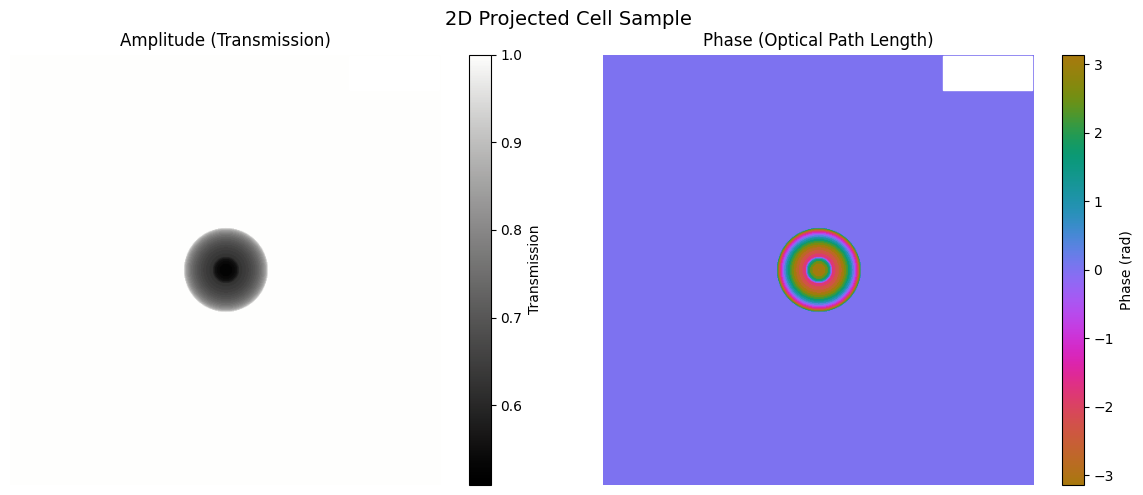

In [8]:
# Visualize the 2D projected cell sample
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

amp = jnp.abs(cell_sample.sample)
phase = jnp.angle(cell_sample.sample)

# Amplitude (transmission)
im0 = axes[0].imshow(amp, cmap=cmo.gray)
axes[0].set_title('Amplitude (Transmission)')
scalebar = ScaleBar(cell_sample.dx, 'm', length_fraction=0.25, color='white')
axes[0].add_artist(scalebar)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], label='Transmission')

# Phase
im1 = axes[1].imshow(phase, cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi)
axes[1].set_title('Phase (Optical Path Length)')
scalebar = ScaleBar(cell_sample.dx, 'm', length_fraction=0.25, color='white')
axes[1].add_artist(scalebar)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], label='Phase (rad)')

plt.suptitle('2D Projected Cell Sample', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Create Illumination Wavefront

We create a collimated (plane wave) illumination to interact with the cell.

In [9]:
illumination_size = 128  # Smaller illumination for scanning

lightwave = jns.models.plane_wave(
    wavelength=wavelength,
    dx=pixel_size,
    grid_size=(illumination_size, illumination_size),
    amplitude=1.0,
)

print(f"Illumination field shape: {lightwave.field.shape}")
print(f"Illumination wavelength: {lightwave.wavelength * 1e9:.0f} nm")
print(f"Illumination dx: {lightwave.dx * 1e6:.2f} microns")
print(f"Illumination FOV: {illumination_size * pixel_size * 1e6:.0f} microns")

Illumination field shape: (128, 128)
Illumination wavelength: 633 nm
Illumination dx: 0.50 microns
Illumination FOV: 64 microns


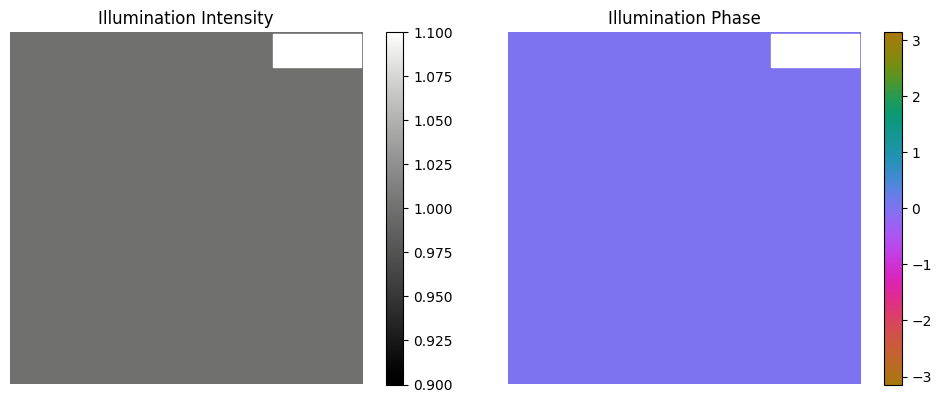

In [10]:
# Visualize illumination
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(jnp.abs(lightwave.field)**2, cmap=cmo.gray)
axes[0].set_title('Illumination Intensity')
scalebar = ScaleBar(lightwave.dx, 'm', length_fraction=0.25, color='white')
axes[0].add_artist(scalebar)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.angle(lightwave.field), cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi)
axes[1].set_title('Illumination Phase')
scalebar = ScaleBar(lightwave.dx, 'm', length_fraction=0.25, color='white')
axes[1].add_artist(scalebar)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 4. Set Microscope Parameters

In [15]:
# Microscope parameters
zoom_factor = 20.0  # 20x magnification
aperture_diameter = 1.5e-3  # 1.5 mm aperture
travel_distance = 0.15  # 150 mm to camera
detector_pixel_size = jnp.array(6.5e-6)  # 6.5 micron camera pixels

print(f"Zoom factor: {zoom_factor}x")
print(f"Aperture diameter: {aperture_diameter * 1e3:.1f} mm")
print(f"Travel distance: {travel_distance * 1e3:.0f} mm")
print(f"Detector pixel size: {detector_pixel_size * 1e6:.1f} µm")

Zoom factor: 20.0x
Aperture diameter: 1.5 mm
Travel distance: 150 mm
Detector pixel size: 6.5 µm


In [16]:
# Cut sample at center of cell
center_pixel = num_pixels // 2
half_size = illumination_size // 2
sample_cut = cell_sample.sample[
    center_pixel - half_size : center_pixel + half_size,
    center_pixel - half_size : center_pixel + half_size
]

sample_region = jns.utils.make_sample_function(
    sample=sample_cut,
    dx=pixel_size,
)

# Generate single diffractogram
diffractogram = jns.scopes.simple_diffractogram(
    sample_cut=sample_region,
    lightwave=lightwave,
    zoom_factor=zoom_factor,
    aperture_diameter=aperture_diameter,
    travel_distance=travel_distance,
    camera_pixel_size=detector_pixel_size,
)

print(f"Diffractogram shape: {diffractogram.image.shape}")
print(f"Diffractogram dx: {diffractogram.dx * 1e6:.2f} µm")

Diffractogram shape: (128, 128)
Diffractogram dx: 6.50 µm


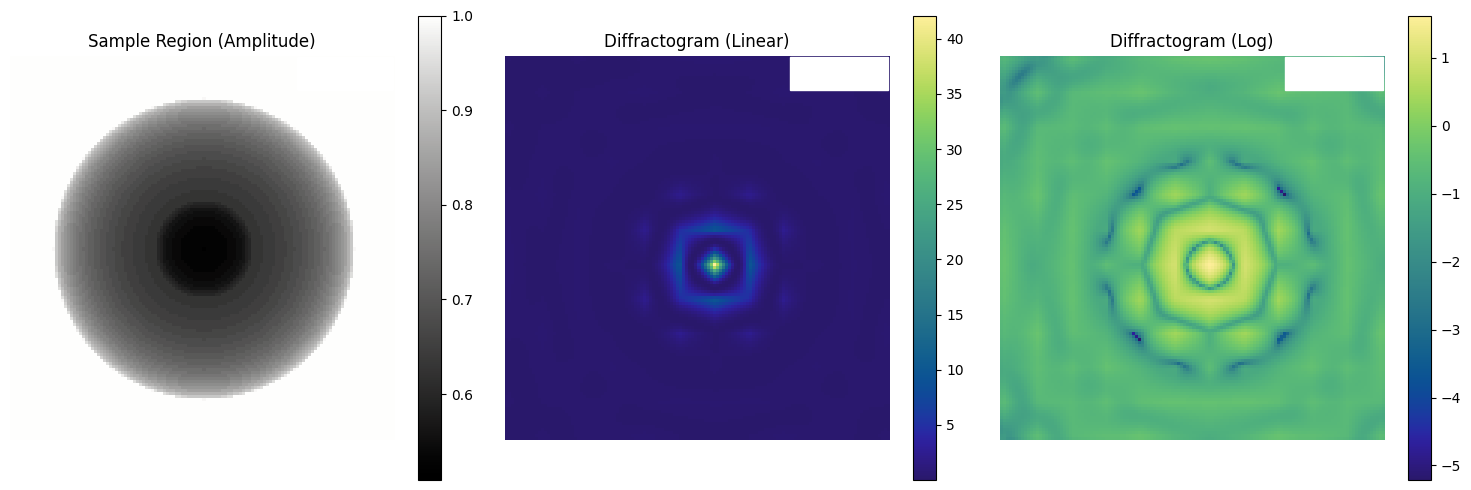

In [17]:
# Visualize single diffractogram
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sample region
im0 = axes[0].imshow(jnp.abs(sample_region.sample), cmap=cmo.gray)
axes[0].set_title('Sample Region (Amplitude)')
scalebar = ScaleBar(sample_region.dx, 'm', length_fraction=0.25, color='white')
axes[0].add_artist(scalebar)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0])

# Diffractogram - linear scale
im1 = axes[1].imshow(diffractogram.image, cmap=cmo.haline)
axes[1].set_title('Diffractogram (Linear)')
scalebar = ScaleBar(diffractogram.dx, 'm', length_fraction=0.25, color='white')
axes[1].add_artist(scalebar)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])

# Diffractogram - log scale
im2 = axes[2].imshow(jnp.log10(diffractogram.image + 1e-10), cmap=cmo.haline)
axes[2].set_title('Diffractogram (Log)')
scalebar = ScaleBar(diffractogram.dx, 'm', length_fraction=0.25, color='white')
axes[2].add_artist(scalebar)
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

In [20]:
# Create scan positions centered on the cell
scan_step = 10e-6  # 10 micron step size
scan_pixel = scan_step / cell_sample.dx

# Center of the sample (where the cell is)
scope_center = jnp.array([num_pixels // 2, num_pixels // 2])  # (x, y) in pixels

num_scan_x = 8
num_scan_y = 8

xx, yy = jnp.meshgrid(
    jnp.arange(num_scan_x) * scan_pixel - (num_scan_x - 1) * scan_pixel / 2,
    jnp.arange(num_scan_y) * scan_pixel - (num_scan_y - 1) * scan_pixel / 2
)
x_positions = xx + scope_center[0]
y_positions = yy + scope_center[1]
positions = jnp.stack([x_positions.ravel(), y_positions.ravel()], axis=1)

print(f"Scan step: {scan_step * 1e6:.0f} µm ({scan_pixel:.1f} pixels)")
print(f"Number of scan positions: {len(positions)}")
print(f"Scan grid: {num_scan_x} x {num_scan_y}")
print(f"Total scan area: {(num_scan_x-1) * scan_step * 1e6:.0f} x {(num_scan_y-1) * scan_step * 1e6:.0f} µm")

Scan step: 10 µm (20.0 pixels)
Number of scan positions: 64
Scan grid: 8 x 8
Total scan area: 70 x 70 µm


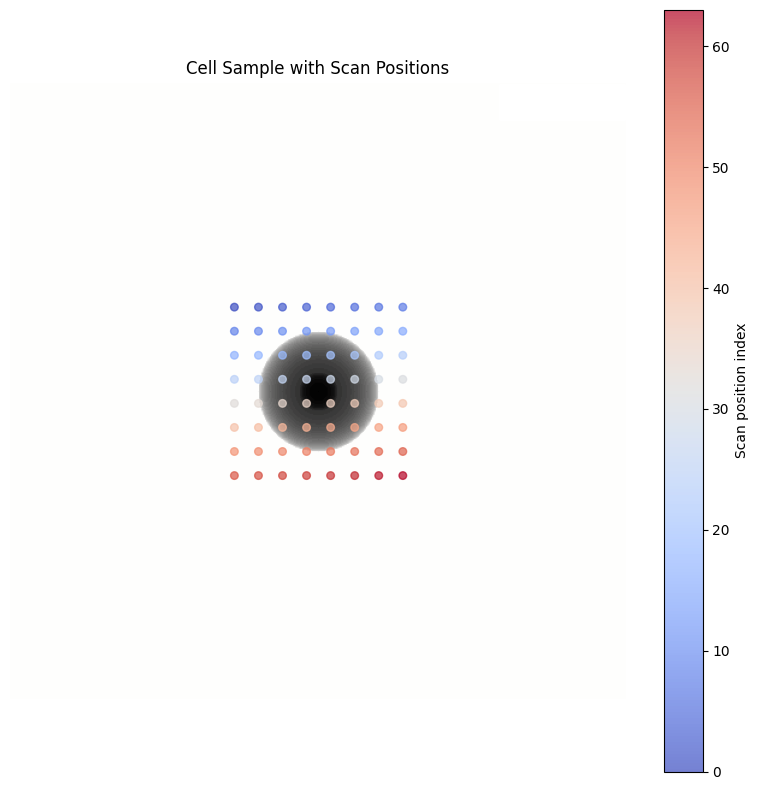

In [21]:
# Visualize scan positions on cell
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

im = ax.imshow(jnp.abs(cell_sample.sample), cmap=cmo.gray)
ax.set_title('Cell Sample with Scan Positions')
scalebar = ScaleBar(cell_sample.dx, 'm', length_fraction=0.25, color='white')
ax.add_artist(scalebar)

# Add scan positions as colored dots
scatter = ax.scatter(positions[:, 0], positions[:, 1], 
                     c=jnp.arange(len(positions)), cmap='coolwarm', 
                     s=30, alpha=0.7, marker='o')
plt.colorbar(scatter, ax=ax, label='Scan position index')
ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
# Run simple_microscope with all scan positions
positions_meters = positions * cell_sample.dx

microscope_data = jns.scopes.simple_microscope(
    sample=cell_sample,
    positions=positions_meters,
    lightwave=lightwave,
    zoom_factor=10.0,
    aperture_diameter=0.001,
    travel_distance=0.1,
    camera_pixel_size=0.00015,
)

print(f"Microscope data shape: {microscope_data.image_data.shape}")
print(f"Number of diffractograms: {microscope_data.image_data.shape[0]}")
print(f"Diffractogram size: {microscope_data.image_data.shape[1:]}")
print(f"Camera pixel size: {microscope_data.dx * 1e6:.2f} µm")

Microscope data shape: (64, 128, 128)
Number of diffractograms: 64
Diffractogram size: (128, 128)
Camera pixel size: 150.00 µm


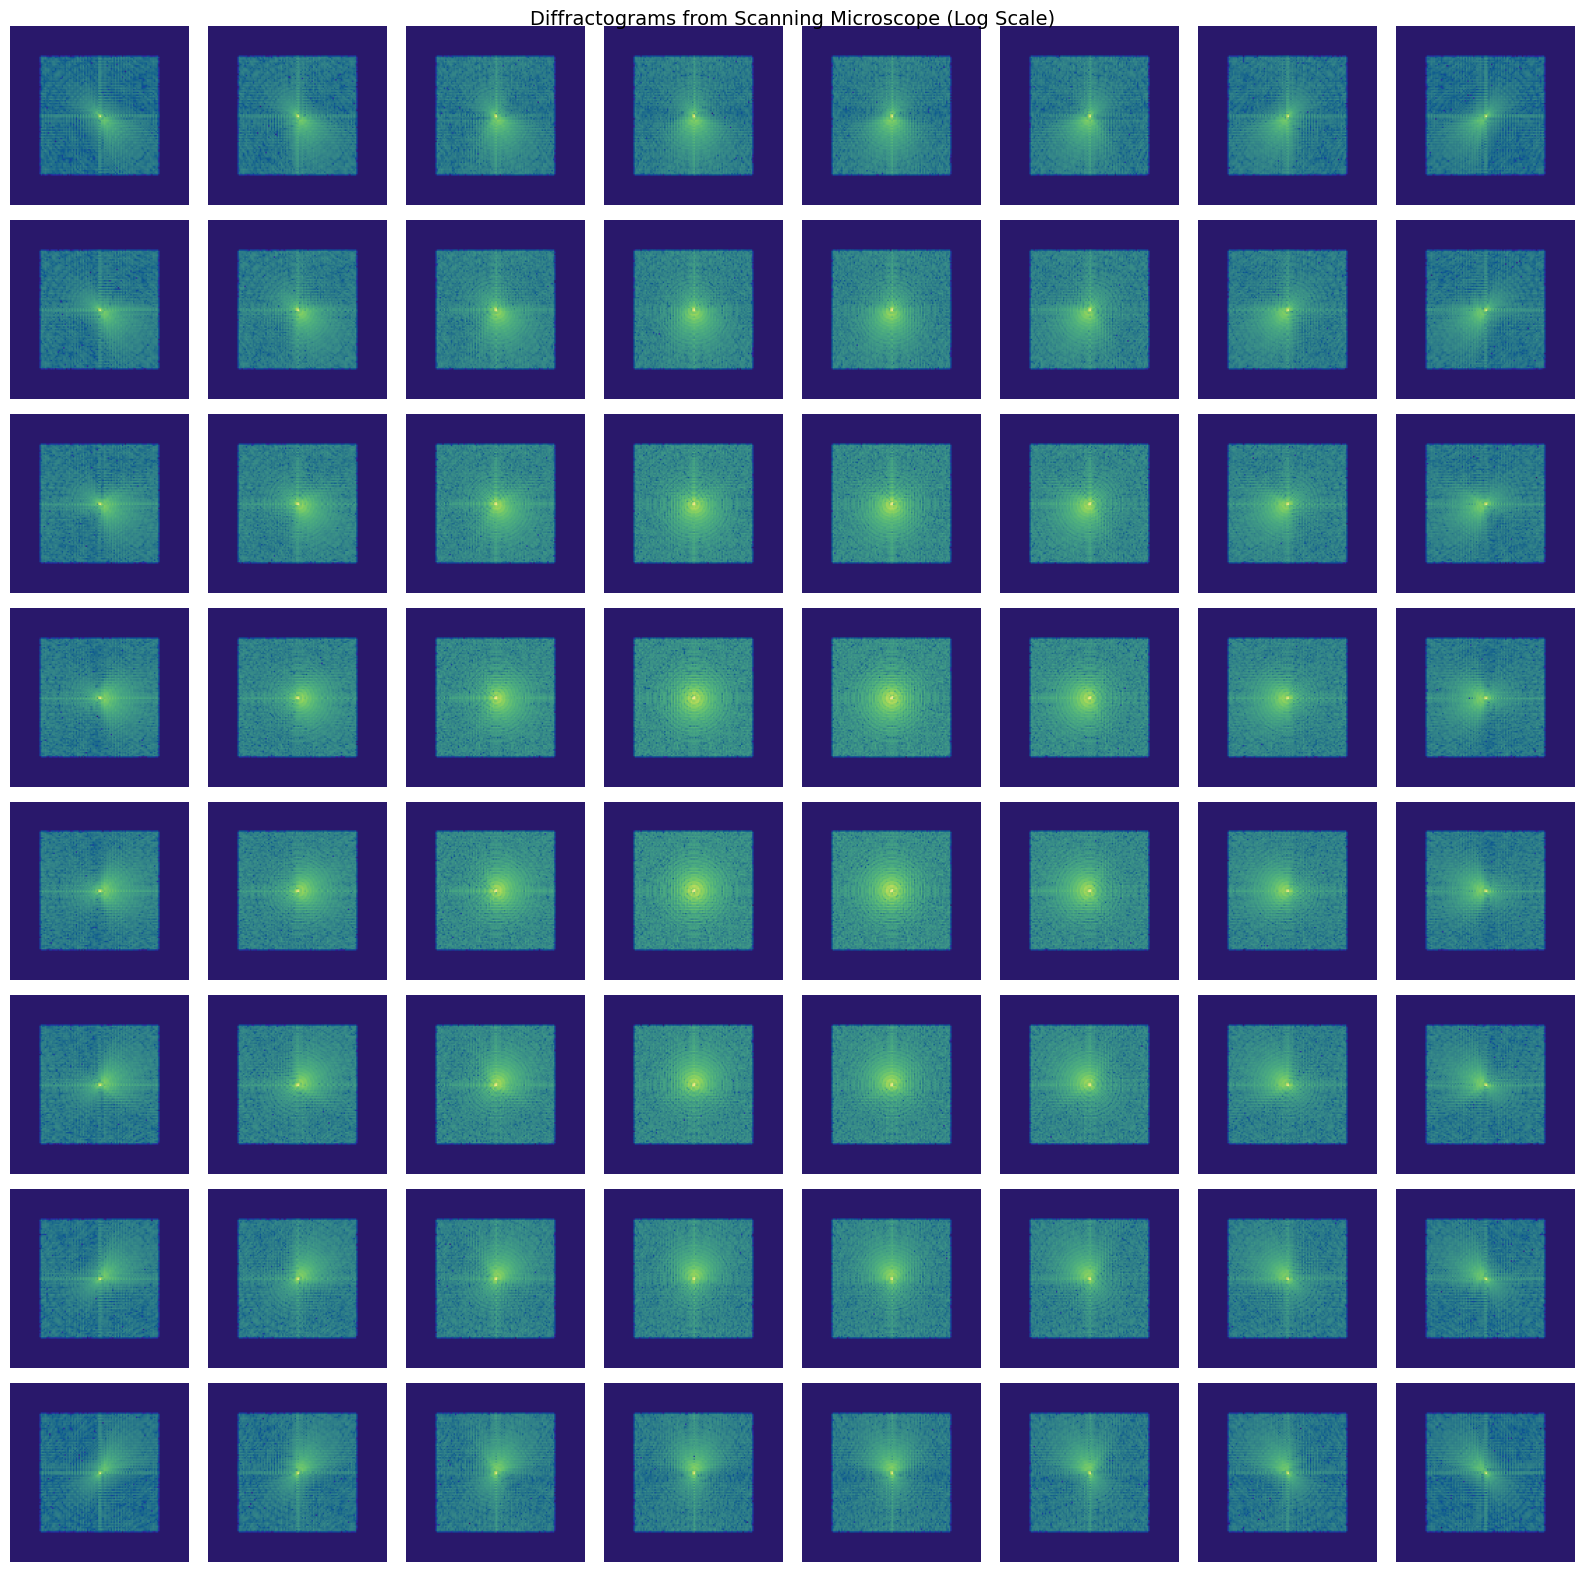

In [23]:
# Visualize diffractograms in a grid matching the scan pattern
fig, axes = plt.subplots(num_scan_y, num_scan_x, figsize=(16, 16))

for i in range(num_scan_y):
    for j in range(num_scan_x):
        idx = i * num_scan_x + j
        ax = axes[i, j]
        ax.imshow(jnp.log10(microscope_data.image_data[idx] + 1e-10), cmap=cmo.haline)
        ax.axis('off')

plt.suptitle('Diffractograms from Scanning Microscope (Log Scale)', fontsize=14)
plt.tight_layout()
plt.show()